# Imports

In [1]:
from __future__ import annotations

import imageio
import io

import numpy as np
from PIL import Image

import torch
import matplotlib.pyplot as plt
import pandas


# pytorch with gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# Loading Data

In [2]:
# creating dummy data with linear regression equation (y = mx + c)
# learn how the inputs X map to the outputs y
X = torch.arange(0, 1, 0.02).reshape(-1, 1)
y = 0.7 * X + 0.3

In [3]:
# split data into train and test sets 
def split_data(X: torch.Tensor, y: torch.Tensor, test_size: float) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    n = round(X.shape[0] * (1 - test_size))
    return X[:n], y[:n], X[n:], y[n:]

X_train, y_train, X_test, y_test = split_data(X, y, 0.2)
print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


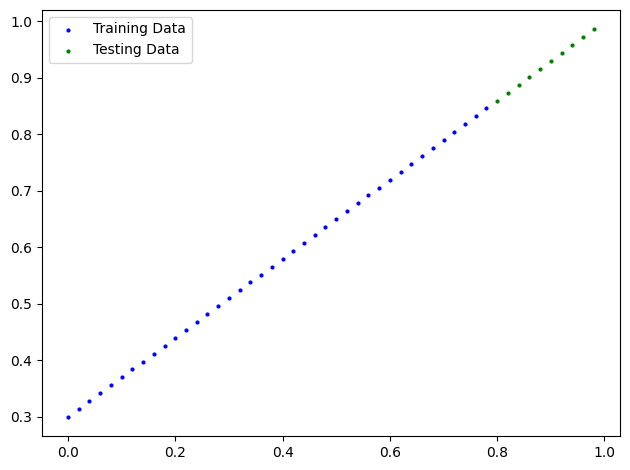

In [4]:
def plot_data(X_train, y_train, X_test, y_test, predictions = None):
    plt.scatter(X_train, y_train, c='b', s=4, label='Training Data')
    plt.scatter(X_test, y_test, c='g', s=4, label='Testing Data')

    if predictions is not None:
        plt.scatter(X_test, predictions, c='r', s=4, label='Predictions')

    plt.legend(['Training Data', 'Testing Data'] + (['Predictions'] if predictions is not None else []))
    plt.tight_layout()

plot_data(X_train, y_train, X_test, y_test)

In [5]:
from torch import nn

# build neural network to predict linear regression values
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
    def __init__(self) -> None:
        super().__init__()

        # init model parameters withh random values, ask pytorch to track and update gradients
        self._weights = nn.Parameter(torch.randn(1, 
                                                 requires_grad=True, 
                                                 dtype=torch.float))
        self._bias = nn.Parameter(torch.randn(1, 
                                              requires_grad=True, 
                                              dtype=torch.float))
    
    # any subclass of nn.Module must override the Module.forward method
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self._weights * X + self._bias

OrderedDict([('_weights', tensor([0.3367])), ('_bias', tensor([0.1288]))])


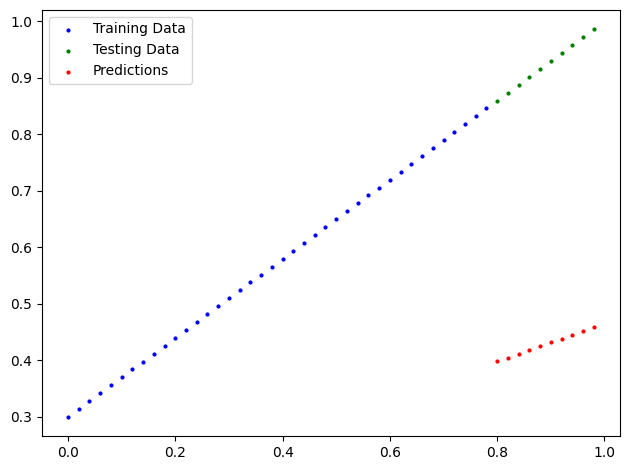

In [6]:
# instantiate model with fixed random seed
torch.manual_seed(42)
model = LinearRegressionModel()

# get predictions of untrained model
y_pred = model.forward(X_test)
plot_data(X_train, y_train, X_test, y_test, y_pred.flatten().detach())

# show untrained random parameter values
print(model.state_dict())

In [7]:
# run model prediction with inference mode for better perforamance
with torch.inference_mode(True):
    y_pred = model(X_test)

### Model Training
- To fit the model parameters to better represent the data.
- For the model to move from some *unknown* parameters (random tensors) to some *known* parameters.
- A way to measure how poor or wrong a model's predictions are (model error) is to use a **loss function**.

### Parts Needed:
- **Loss Function:** A function to measure how wrong a model's predictions are to the ideal outputs, where the lower the value the better the model.
- **Optimizer:** Takes into account the loss of a model and adjusts a model's parameters accordingly (weights and biases) to improve the output of the loss function.
- **Training and Testing Loop:** Needed for PyTorch

In [8]:
# model parameters:
print(model.state_dict())

OrderedDict([('_weights', tensor([0.3367])), ('_bias', tensor([0.1288]))])


In [9]:
# build loss function
loss_fn = nn.L1Loss()

# build optimizer
optimizer = torch.optim.SGD(
    params=model.parameters(), 
    lr=0.01
)

### Build Training and Testing Loop
- Loop through the data
- Forward pass - data moving through model's `forward()` method
- Calculate the loss - compare forward pass predictions to ground truth labels, `y_test`
- Optimizer zero grad
- Loss backward - move backwards through the network to calculate the gradients of each parameter with respect to the loss calculated (**backpropagation**)
- Optimize step - use the optimizer to adjust model parameters to try and improve/lower the loss (**gradient descent**)

In [10]:
EPOCHS = 100 # number of loops through the data
LOSS_FN = nn.L1Loss()
OPTIMIZER = torch.optim.SGD(params=model.parameters(), 
                            lr=0.01)

# iterate over data
for epoch in range(EPOCHS):
    # set model to training mode, sets all parameters that require gradients to require gradients
    model.train(True)
    
    # 1. Forward pass
    y_pred = model.forward(X_train)

    # 2. Calculate loss
    loss = LOSS_FN(y_pred, y_train)

    # 3. Optimizer zero grad for computation optimization
    OPTIMIZER.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the models
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    OPTIMIZER.step()

### Compiled GIF of model training

In [13]:
# model and hyperparameters
torch.manual_seed(200)
model_0 = LinearRegressionModel()
epochs = 300
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_0.parameters(), 0.02)

# build training gif
images: list[Image.Image] = []

# training loop
for epoch in range(epochs):
    # model training loop
    model_0.train(True)
    y_pred = model_0.forward(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # get model results
    model_0.eval()
    y_pred = model_0.forward(X_test)

    # plot predictions
    fig = plt.figure()
    plt.yticks(list(np.arange(-3, 1.5, 0.5)))
    plt.ylim(-3, 1.5)

    plt.scatter(X_train, y_train, c='b', s=4, label='Training Data')
    plt.scatter(X_test, y_test, c='g', s=4, label='Testing Data')
    plt.scatter(X_test, y_pred.detach(), c='r', s=4, label='Predictions')
    fig.legend(['Training Data', 'Testing Data', 'Predictions'], loc='lower left')
    plt.tight_layout()

    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()

    plot_img = Image.fromarray(data.reshape((int(h), int(w), -1)))
    images.append(plot_img)
    plt.close()

images[0].save('animation.gif',
               save_all=True,
               append_images=images[1:], # append rest of the images
               loop=0)

![SegmentLocal](animation.gif "segment")

### Model Saving

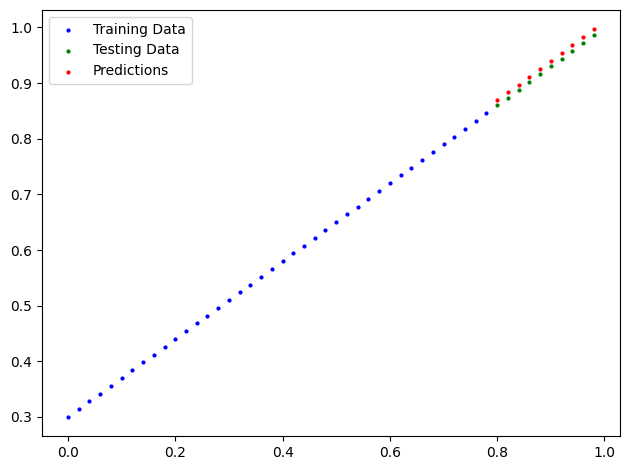

In [20]:
with open('linreg-model.pickle', 'wb') as file:
    torch.save(model_0, file)

with open('linreg-model.pickle', 'rb') as file:
    model_0: nn.Module = torch.load(file)

y_pred = model_0.forward(X_test)
plot_data(X_train, y_train, X_test, y_test, y_pred.flatten().detach())

In [22]:
model_0.state_dict()

OrderedDict([('_weights', tensor([0.7091])), ('_bias', tensor([0.3017]))])